In [13]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib

import numpy as np

from sky_spot import env

sns.set_style('whitegrid')

In [66]:
EXP_DIR = pathlib.Path('../../exp-new-sliced')
RESULT_DIR = pathlib.Path('../../results-new-sliced')


TRACE = 'two_exp'
TRACE_DIRS = {
    'real': pathlib.Path('../../data/real/ping_based/random_start_time'),
    'two_exp': pathlib.Path(
    '../../data/two_exp/gap_600-real_mean-longer')
}

TRACE_NAMES = {
    'real': 'real_overhead={overhead}',
    'two_exp': 'exp-gap_600-real_mean_over={overhead}'
}

TRACE_TYPES = {
    'real': 'us-west-2a_v100_1',
    'two_exp': 'exp_gap_600-real_mean'
}

# TRACE_DIR = 
TRACE_DIR = TRACE_DIRS[TRACE]
TRACE_NAME = TRACE_NAMES[TRACE]
TRACE_TYPE = TRACE_TYPES[TRACE]



# OVERHEADS = [0.01, 0.1, 0.15, 0.2]
# OVERHEADS = [0.01, 0.1]
OVERHEADS = [0.1]
# overhead = 0.1
slice_interval = 0.5


In [67]:
# TRACE_PATH = TRACE_DIR / TRACE_TYPE
TRACE_PATH = TRACE_DIR / 'gap_600-real_mean-longer_random'
spot_avail_traces = []
envs = env.TraceEnv.create_env(TRACE_PATH, 0)
for e in envs:
    spot_avail_traces.append(
        [1 - i for i in e.get_trace_before_end(52 * 3600)])

spot_avail_traces = np.array(spot_avail_traces)

slice_gap = int(slice_interval * 3600) // 600

sliced = spot_avail_traces.reshape(len(spot_avail_traces), -1, slice_gap)
sliced_spot_frac = sliced.mean(axis=-1)
print(sliced_spot_frac)
print(len(sliced_spot_frac))
sliced_spot_per_trace_mean = sliced_spot_frac.mean(axis=1)
sliced_spot_per_trace_std = sliced_spot_frac.std(axis=1)

[[1.         1.         1.         ... 1.         0.33333333 0.        ]
 [1.         0.         1.         ... 0.33333333 1.         0.        ]
 [1.         0.66666667 0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.         1.        ]
 [1.         1.         1.         ... 0.         1.         1.        ]
 [1.         0.66666667 0.66666667 ... 0.         0.66666667 1.        ]]
1000


In [18]:
greedy_cost = {}
time_sliced_cost = {}
loose_time_sliced_cost = {}


for overhead in OVERHEADS:
    EXP_PATH = EXP_DIR / TRACE_NAME.format(overhead=overhead)
    RESULT_PATH = RESULT_DIR / (TRACE_NAME.format(overhead=overhead) + '.json')
    file_name = f'-trace-{TRACE_TYPE}-ddl=*-dur=48.0-over={overhead}'


    df = pd.read_json(RESULT_PATH)
    df = df[~df['use_avg']]

    def get_algorithm_cost(alg: str):
        alg_df = df[df['algorithm'] == alg]
        if len(alg_df) > 1:
            alg_df = alg_df[alg_df['slice interval'] == slice_interval]
            if 'max slice slacks' in alg_df.columns:
                alg_df = alg_df[alg_df['max slice slacks'].isna() & alg_df['max total slacks'].isna()]
        alg_cost = alg_df['cost'].values[0]
        return np.array(alg_cost)

    greedy_cost[overhead] = get_algorithm_cost('greedy')
    time_sliced_cost[overhead] = get_algorithm_cost('time_sliced')
    loose_time_sliced_cost[overhead] = get_algorithm_cost('loose_time_sliced')
    optimal_cost = get_algorithm_cost('ideal_ilp')


FileNotFoundError: [Errno 2] No such file or directory: '../../data/two_exp/gap_600-real_mean_random-3000/exp_gap_600-real_mean'

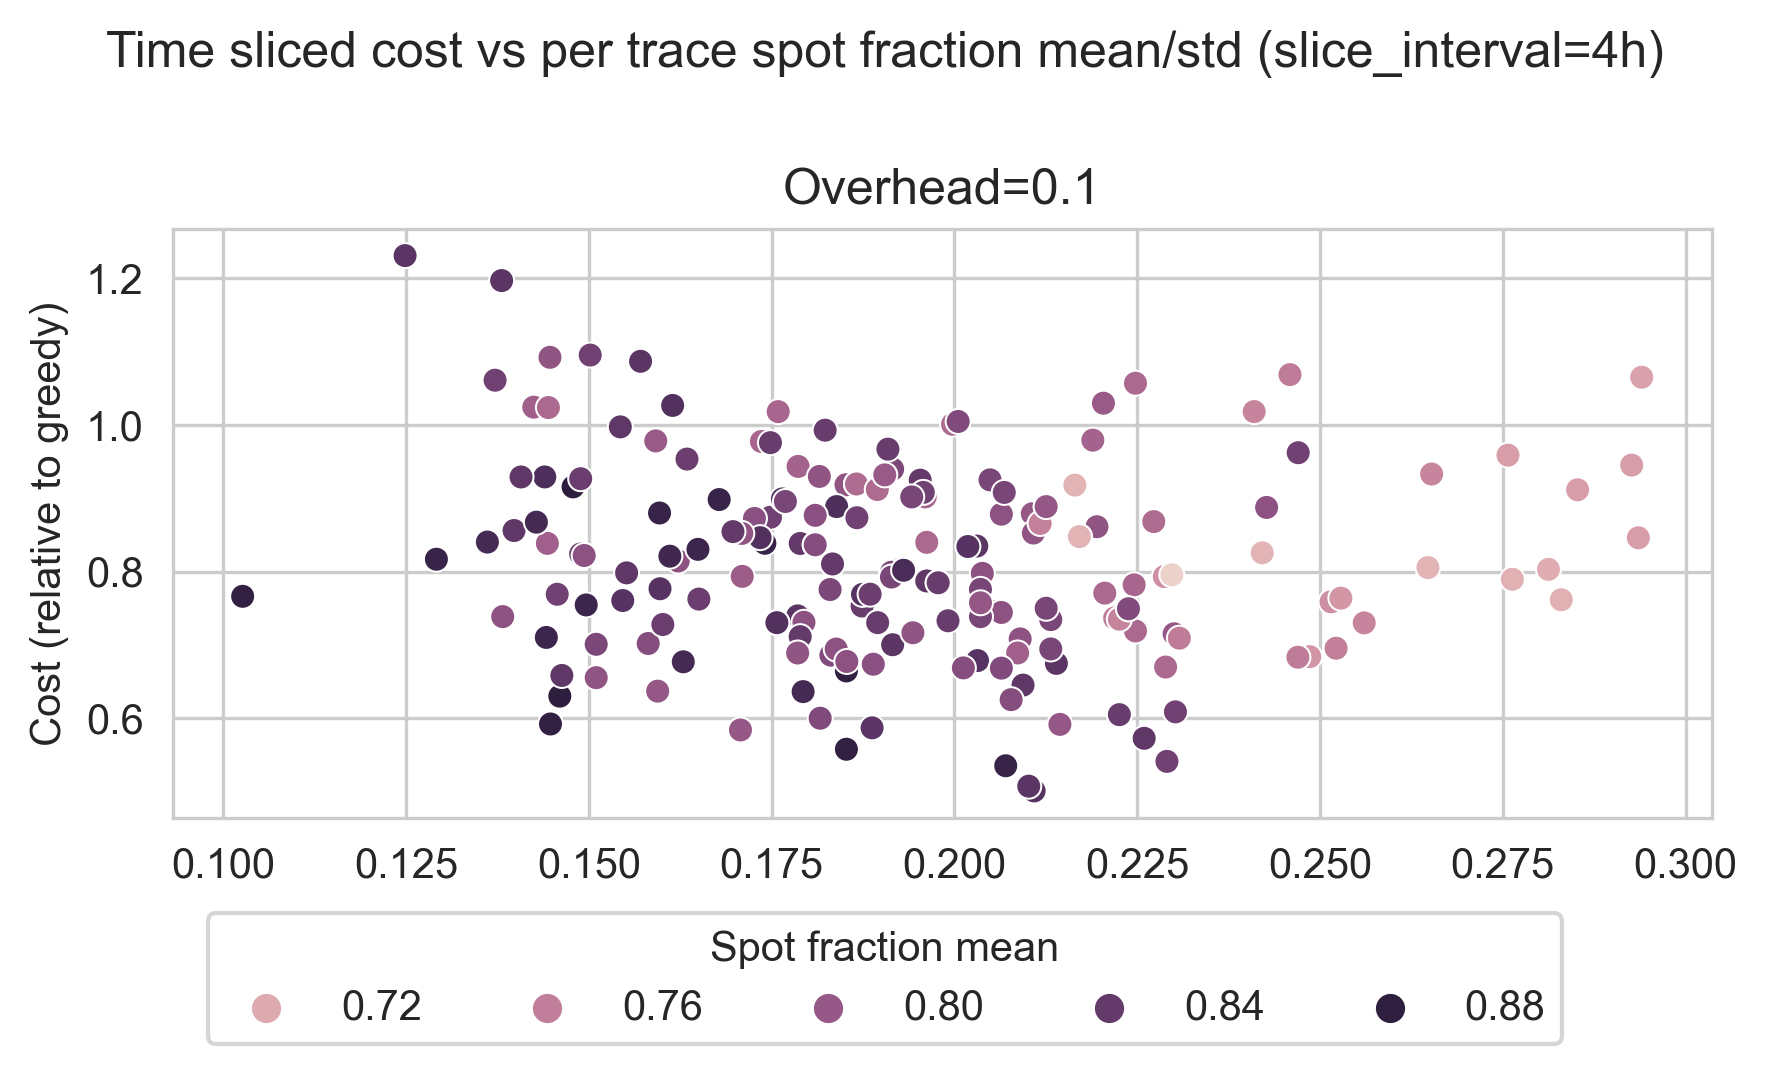

In [ ]:
fig = plt.figure(dpi=300, figsize=(6, 3 * (len(OVERHEADS) // 2 + 1)))
if len(OVERHEADS) > 2:
    axes = fig.subplots(len(OVERHEADS) // 2 + len(OVERHEADS) % 2, 2)
elif len(OVERHEADS) == 2:
    axes = fig.subplots(1, len(OVERHEADS))
else:
    axes = [fig.subplots(1, 1)]
np.random.seed(0)
# sampled_indices = np.arange(1000)
sampled_indices = np.random.choice(len(sliced_spot_per_trace_mean), 200)
# sampled_indices = np.nonzero((sliced_spot_per_trace_mean < 0.8) & (sliced_spot_per_trace_mean > 0.7))
# sampled_indices = np.nonzero((sliced_spot_per_trace_std < 0.4) & (sliced_spot_per_trace_std > 0.3))
for i, overhead in enumerate(OVERHEADS):
    if len(OVERHEADS) > 2:
        ax = axes[i//2, i%2]
    else:
        ax = axes[i]
    # ax = axes[i]
    # sns.scatterplot(x=sliced_spot_per_trace_mean[sampled_indices],
    #                 y=time_sliced_cost[overhead][sampled_indices],
    #                 hue=sliced_spot_per_trace_std[sampled_indices],
    #                 ax=ax)
    sns.scatterplot(x=sliced_spot_per_trace_std[sampled_indices],
                    y=time_sliced_cost[overhead][sampled_indices] /
                    greedy_cost[overhead][sampled_indices],
                    hue=sliced_spot_per_trace_mean[sampled_indices],
                    ax=ax)
    # sns.scatterplot(x=sliced_spot_per_trace_std[sampled_indices],
    #                 y=loose_time_sliced_cost[overhead][sampled_indices] /
    #                 greedy_cost[overhead][sampled_indices],
    #                 hue=sliced_spot_per_trace_mean[sampled_indices],
    #                 ax=ax)
    if i > (len(OVERHEADS) - 1) // 2:
        ax.set_xlabel('Stdev of spot fraction per trace')
    if i % 2 == 0:
        ax.set_ylabel('Cost (relative to greedy)')
        # ax.set_ylabel('Cost (relative to time_sliced)')
    # ax.legend(title='spot fraction std', loc='lower left')
    ax.legend().set_visible(False)
    ax.set_title(f'Overhead={overhead}')
handler_ax = axes[0, 0] if len(OVERHEADS) > 2 else axes[0]
fig.legend(title='Spot fraction mean', loc='lower center', ncol=6, handles=handler_ax.get_legend_handles_labels()[0], bbox_to_anchor=(0.5, -0.15))
fig.suptitle(
    f'Time sliced cost vs per trace spot fraction mean/std (slice_interval={slice_interval}h)',
    y=1)
fig.tight_layout()


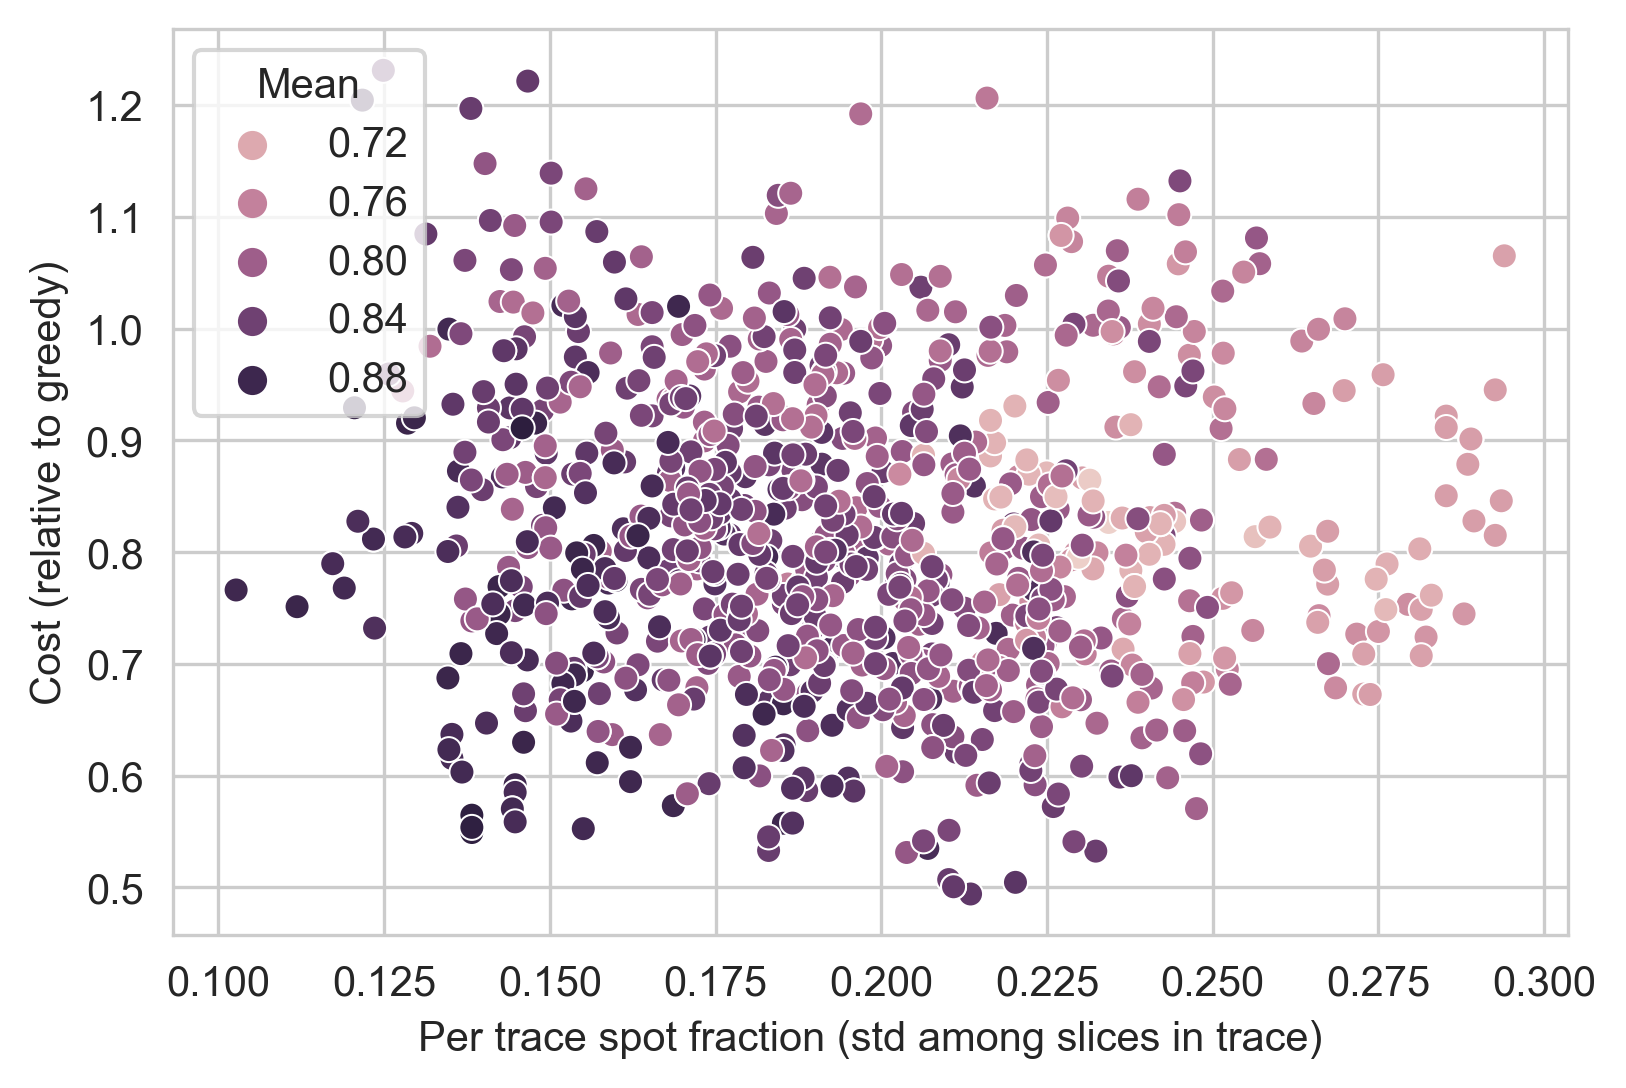

In [ ]:
fig = plt.figure(dpi=300, figsize=(6, 4))
ax = fig.add_subplot(111)
sns.scatterplot(x=sliced_spot_per_trace_std, y=time_sliced_cost[overhead] / greedy_cost[overhead], hue=sliced_spot_per_trace_mean, ax=ax)
# sns.scatterplot(x=sliced_spot_per_trace_std, y=loose_time_sliced_cost / greedy_cost, label='loose time sliced', ax=ax)
ax.set_xlabel('Per trace spot fraction (std among slices in trace)')
ax.set_ylabel('Cost (relative to greedy)')
ax.legend(title='Mean')

Text(0.5, 1.0, 'Per trace spot fraction (0.5-hour slice; Exponential distribution)')

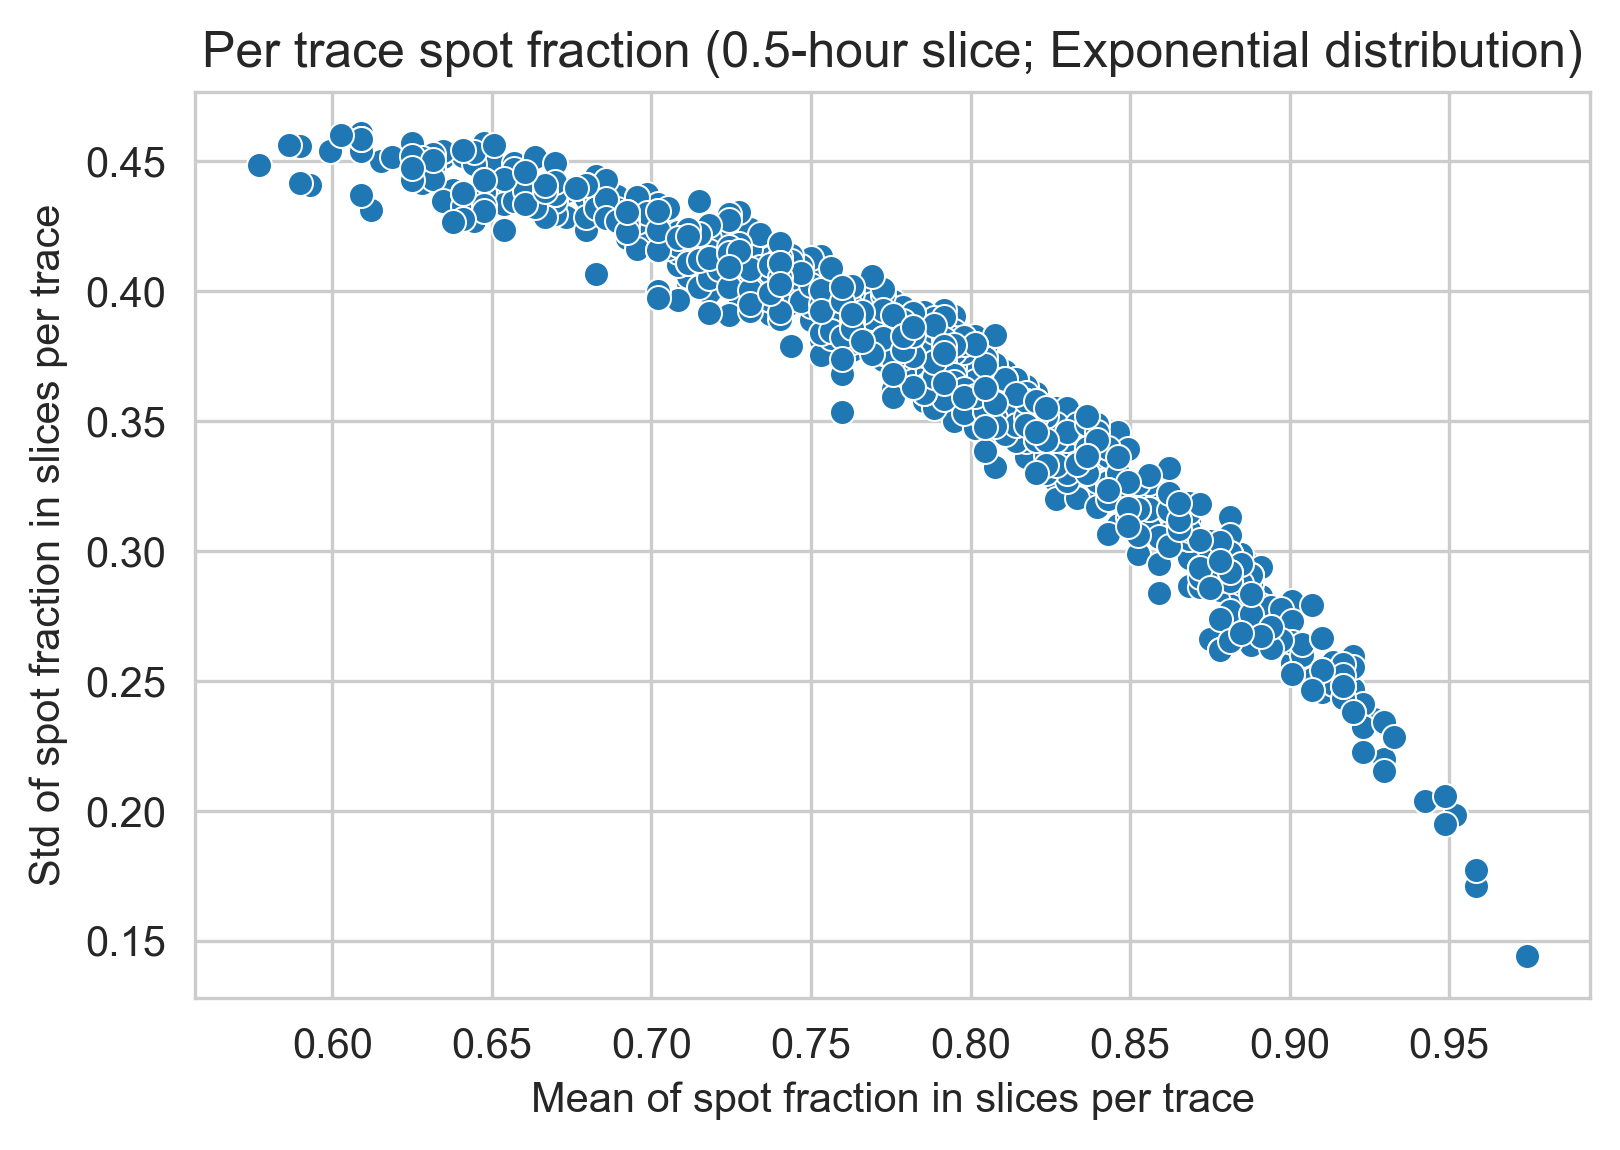

In [68]:
fig = plt.figure(dpi=300, figsize=(6, 4))
ax = fig.add_subplot(111)
sns.scatterplot(x=sliced_spot_per_trace_mean, y=sliced_spot_per_trace_std, ax=ax)
# sns.scatterplot(x=sliced_spot_per_trace_std, y=loose_time_sliced_cost / greedy_cost, label='loose time sliced', ax=ax)
ax.set_xlabel('Mean of spot fraction in slices per trace')
ax.set_ylabel('Std of spot fraction in slices per trace')
# ax.set_title(f'Per trace spot fraction ({slice_interval}-hour slice)')
ax.set_title(f'Per trace spot fraction ({slice_interval}-hour slice; Exponential distribution)')

In [ ]:
DDL_GAPS = 52 * 3600 // 600

algorithm = 'loose_time_sliced'



EXP_PATH = EXP_DIR / TRACE_NAME.format(overhead=overhead)
RESULT_PATH = RESULT_DIR / (TRACE_NAME.format(overhead=overhead) + '.json')
TRACE_PATH = TRACE_DIR / TRACE_TYPE
file_name = f'-trace-{TRACE_TYPE}-ddl=*-dur=48.0-over={overhead}'

alg_trace = list(EXP_PATH.glob(f'{algorithm}_{slice_interval:.1f}h{file_name}'))[0]

trace = json.load(alg_trace.open('r'))
request_traces = [[int(i['RequestType'] - 1) for i in h[1:]] for h in trace['history']]
for i, r in enumerate(request_traces):
    r = r[:DDL_GAPS]
    if len(r) < DDL_GAPS:
        r += [0] * (DDL_GAPS - len(r))
    request_traces[i] = r
request_traces = np.array(request_traces)

slice_gap = int(slice_interval * 3600 // 600)
sliced = request_traces.reshape(len(request_traces), -1, slice_gap)




In [ ]:
# Number of on-demand per slice
slacks_counts = ((sliced[..., 1:] - sliced[..., :-1]) == -1).sum(axis=-1)
slacks_counts

array([[2, 0, 3, ..., 0, 0, 1],
       [0, 2, 2, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 2, ..., 1, 2, 0],
       [0, 2, 2, ..., 0, 0, 1],
       [1, 2, 0, ..., 0, 0, 1]])

[1.33333333 1.16666667 1.375      1.875      1.75       1.25
 1.22222222 1.57142857 1.71428571 1.66666667 1.5        1.85714286
 1.5        1.3        1.7        1.55555556 1.625      1.6
 1.625      1.44444444 1.5        1.22222222 1.28571429 1.33333333
 1.625      1.1        1.83333333 1.55555556 1.55555556 1.57142857
 1.54545455 1.375      1.625      1.44444444 1.5        1.71428571
 1.14285714 1.71428571 1.5        1.66666667 1.22222222 1.625
 1.125      1.66666667 1.6        1.3        1.71428571 1.36363636
 1.66666667 1.75       1.5        1.44444444 1.42857143 1.33333333
 1.22222222 1.2        1.77777778 1.3        1.5        1.57142857
 1.42857143 1.375      1.625      1.5        1.55555556 1.16666667
 1.55555556 1.22222222 1.33333333 1.11111111 1.55555556 1.375
 1.66666667 1.2        1.33333333 1.28571429 1.55555556 1.625
 1.33333333 1.45454545 1.44444444 1.75       1.42857143 1.5
 1.75       1.33333333 1.2        1.57142857 1.57142857 1.375
 1.4        1.57142857 1.11111111 1

Text(0, 13.274, '12.27')

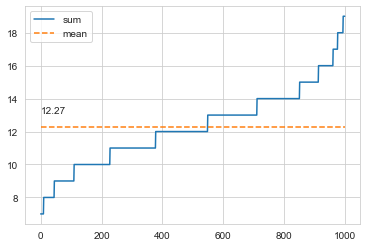

In [ ]:
slacks_sum = slacks_counts.sum(-1)
slacks_max = slacks_counts.max(-1)
# # Take average of non-zero values in each column
slacks_mean = slacks_sum / (slacks_counts > 0).sum(-1)
slacks_mean[np.isnan(slacks_mean)] = 0
print(slacks_mean)
# # Take std of each column excluding the zero values
slacks_std = np.nanstd(np.where(np.isclose(slacks_counts, 0), np.nan, slacks_counts), -1)
slacks_std[np.isnan(slacks_std)] = 0

# slacks_mean = slacks_counts.mean(-1)
# slacks_std = slacks_counts.std(-1)
ax = sns.lineplot(x=np.arange(len(slacks_sum)), y=sorted(slacks_sum), label='sum')
sns.lineplot(x=[0, len(slacks_sum)], y=[slacks_sum.mean(), slacks_sum.mean()], ax=ax, label='mean', ls='--')
ax.text(0, slacks_sum.mean()+1, f'{slacks_sum.mean():.2f}', va='center', ha='left')

Text(0, 1.9658897047397048, '1.47')

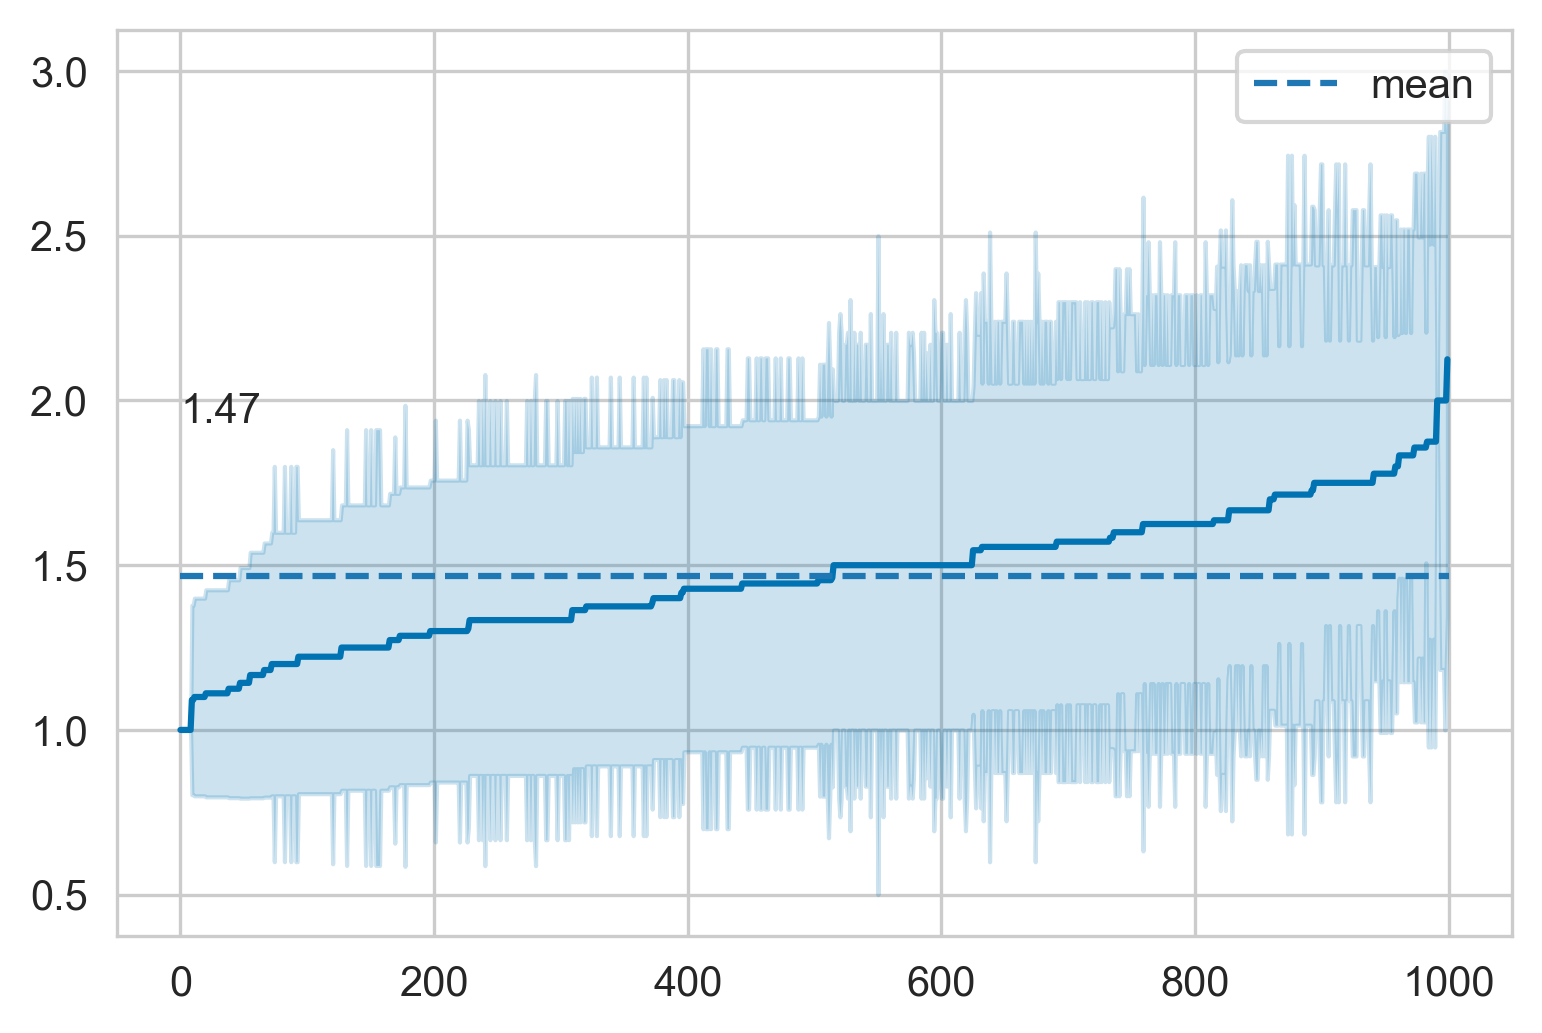

In [ ]:
colors = sns.color_palette('colorblind')
fig = plt.figure(dpi=300, figsize=(6, 4))
ax = fig.add_subplot(111)
sorted_indices = np.argsort(slacks_mean)
sns.lineplot(x=np.arange(len(slacks_mean)), y=slacks_mean[sorted_indices], ax=ax, color=colors[0])
sns.lineplot(x=[0, len(slacks_sum)], y=[slacks_mean.mean(), slacks_mean.mean()], ax=ax, label='mean', ls='--', errorbar=None)
ax.fill_between(np.arange(len(slacks_mean)), slacks_mean[sorted_indices] - slacks_std[sorted_indices], slacks_mean[sorted_indices] + slacks_std[sorted_indices], alpha=0.2, color=colors[0])
ax.text(0, slacks_mean.mean() + .5, f'{slacks_mean.mean():.2f}', va='center', ha='left')

# colors = sns.color_palette('colorblind')
# fig = plt.figure(dpi=300, figsize=(6, 4))
# ax = fig.add_subplot(111)

# ax2 = ax.twinx()
# sns.lineplot(x=np.arange(len(slacks_mean)), y=loose_time_sliced_cost[overhead][sorted_indices] / time_sliced_cost[overhead][sorted_indices], ax=ax2, color=colors[1])
# sns.scatterplot(x=sliced_spot_per_trace_std, y=slacks_mean, ax=ax)

<AxesSubplot: >

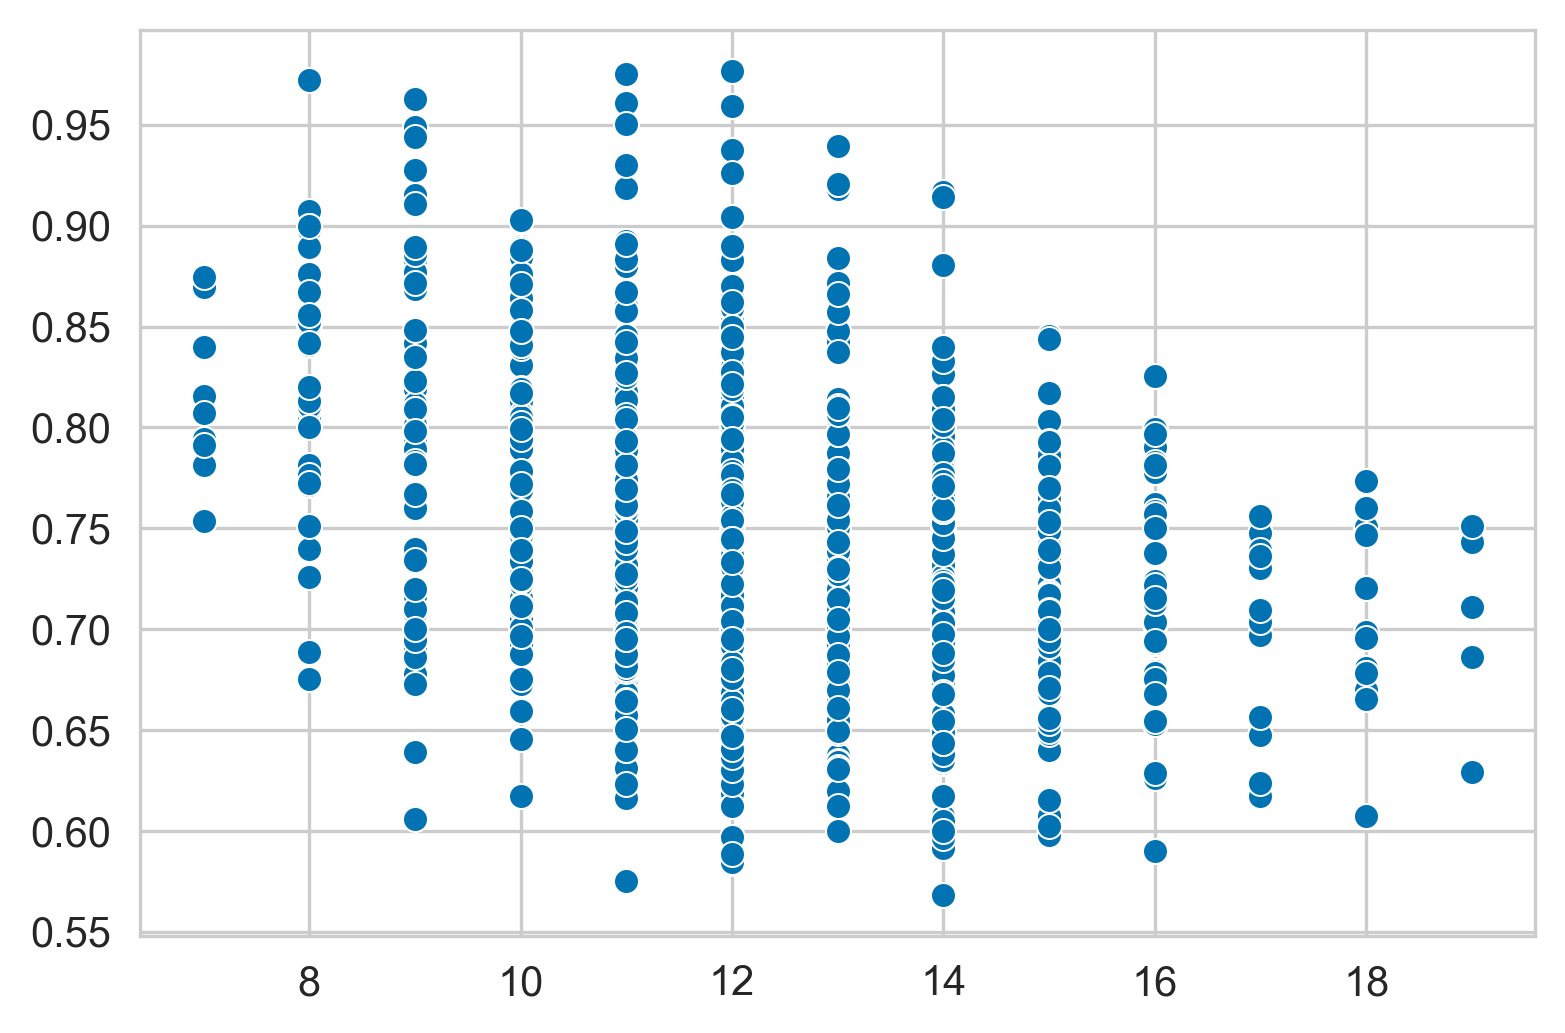

In [ ]:
colors = sns.color_palette('colorblind')
fig = plt.figure(dpi=300, figsize=(6, 4))
ax = fig.add_subplot(111)

x = slacks_sum
sorted_indices = np.argsort(x)
sns.scatterplot(x=x[sorted_indices], y=loose_time_sliced_cost[overhead][sorted_indices] / time_sliced_cost[overhead][sorted_indices], ax=ax, color=colors[0])
# ax.errorbar(x=x[sorted_indices], y=loose_time_sliced_cost[overhead][sorted_indices] / time_sliced_cost[overhead][sorted_indices], xerr=slacks_std[sorted_indices], fmt='none', color=colors[0], alpha=0.2)

# colors = sns.color_palette('colorblind')
# fig = plt.figure(dpi=300, figsize=(6, 4))
# ax = fig.add_subplot(111)

# ax2 = ax.twinx()
# sns.lineplot(x=np.arange(len(slacks_mean)), y=loose_time_sliced_cost[overhead][sorted_indices] / time_sliced_cost[overhead][sorted_indices], ax=ax2, color=colors[1])
# sns.scatterplot(x=sliced_spot_per_trace_std, y=slacks_mean, ax=ax)